In [289]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

#Анализ врачей Москвы: СберЗдоровье и ПроДокторов

**Цель проекта**
Провести анализ данных о врачах Москвы, собранных с онлайн-платформ СберЗдоровье и ПроДокторов, с акцентом на географическое распределение, ценовую политику и рейтинги специалистов.


Описание источников данных


**СберЗдоровье** — цифровая платформа, предоставляющая пользователям возможность **записи к врачам**, а также информацию о стоимости приёма, рейтингах и доступности специалистов по районам города.


**ПроДокторов** — **независимый ресурс, ориентированный на отзывы пациентов** и рейтинговую оценку врачей и клиник, что позволяет судить о качестве оказываемых медицинских услуг.


Этапы работы

1)Сбор и структурирование данных о врачах Москвы с обеих платформ.

2)Сравнительный анализ стоимости приёма, рейтингов, географического

3)распределения специалистов, анализ текста отзывов.

4)Выявление лучших врачей и районов, где сочетание цены, рейтинга и доступности является наиболее выгодным для пациента.


**Минимально-жизнеспособный продукт**


**Скибиди ДокДок** — прототип сервиса, который:


-подсказывает лучшие предложения по рейтингу и цене в выбранном районе;


-показывает средние показатели по Москве;


-помогает пользователю выбрать оптимального врача с учётом репутации, цены и геолокации.


Долгосрочная цель


-Построение единого профиля врача с расчётом агрегированного рейтинга, основанного на данных разных платформ.
Для этого необходим детальный анализ различий между источниками — в ценах, рейтингах и опыте специалистов.

ТУТ ОПИСАНИЕ СТРУКТУРЫ НАШИХ ДАТАСЕТОВ И ВСЕХ ПРИЗНАКОВ

#Датасет

In [290]:
doctors = pd.read_csv('https://github.com/yyaroslavskiy/cuddly-chainsaw/raw/refs/heads/develop/eda/merge/doctors.csv')

In [291]:
del doctors['Unnamed: 0']

In [292]:
doctors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38865 entries, 0 to 38864
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   38865 non-null  object 
 1   experience             16946 non-null  float64
 2   rating_sber            31918 non-null  float64
 3   review_count_sber      31919 non-null  float64
 4   price_sber             4199 non-null   float64
 5   link_sber              31919 non-null  object 
 6   clinics_count_sber     31919 non-null  float64
 7   clinic_1_name_sber     4360 non-null   object 
 8   clinic_1_address_sber  4360 non-null   object 
 9   clinic_1_metro_sber    4304 non-null   object 
 10  clinic_2_name_sber     868 non-null    object 
 11  clinic_2_address_sber  868 non-null    object 
 12  clinic_2_metro_sber    827 non-null    object 
 13  clinic_3_name_sber     142 non-null    object 
 14  clinic_3_address_sber  142 non-null    object 
 15  cl

In [293]:
doctors.describe()

,experience,rating_sber,review_count_sber,price_sber,clinics_count_sber,price_prod,rating_prod,review_count_prod,clinics_count_prod
count,16946.000000,31918.000000,31919.000000,4199.000000,31919.000000,5894.000000,17214.000000,25657.000000,25657.000000
mean,21.661159,4.250658,5.814812,5010.827102,0.169523,4698.710892,2.557976,7.539151,1.482286
std,12.634724,0.497346,31.287880,3932.463460,0.471099,4039.904336,1.545650,18.488260,0.816692
min,1.000000,0.000000,0.000000,1000.000000,0.000000,500.000000,0.000000,0.000000,1.000000
25%,11.000000,4.000000,0.000000,3000.000000,0.000000,2800.000000,1.500000,0.000000,1.000000
50%,20.000000,4.300000,0.000000,3700.000000,0.000000,3500.000000,2.500000,2.000000,1.000000
75%,31.000000,4.500000,3.000000,5500.000000,0.000000,5400.000000,3.900000,8.000000,2.000000
max,71.000000,5.000000,1131.000000,100000.000000,8.000000,150000.000000,5.000000,627.000000,13.000000


посмотрим пропуски(функция с сема)

In [294]:
#Воспользуемся следующей функцией, которая предоставляет отчет о пропусках в данных

def missing_values_table(df):
    """
    Функция возвращает резюме по пропущенным значениям
    """
    # Общее число пропусков
    mis_val = df.isnull().sum()

    # Процент пропусков
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Создадит таблицу с результатом
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Переименнуем колонки
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Отсортируем по проценту пропущенных значений
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Выведем некоторую информацию
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")

    return mis_val_table_ren_columns

missing_values_table(doctors)

Your selected dataframe has 33 columns.
There are 30 columns that have missing values.


,Missing Values,% of Total Values
clinic_3_metro_sber,38732,99.7
clinic_3_address_sber,38723,99.6
clinic_3_name_sber,38723,99.6
clinic_2_metro_sber,38038,97.9
clinic_2_address_sber,37997,97.8
clinic_2_name_sber,37997,97.8
clinic_3_metro_prod,36627,94.2
clinic_3_name_prod,36251,93.3
clinic_3_address_prod,36251,93.3
price_sber,34666,89.2


#Платформа, с которой взяли информацию о враче

FE - добавление колонки источника `'doctor_source'` откуда мы взяли врача

In [295]:
def get_doctor_source(row):
    has_sber = pd.notna(row['link_sber'])
    has_prod = pd.notna(row['link_prod'])

    if has_sber and has_prod:
        return 'Обе платформы'
    elif has_sber:
        return 'SberHealth'
    elif has_prod:
        return 'ProDoctorov'

doctors['doctor_source'] = doctors.apply(get_doctor_source, axis=1)

In [296]:
doctors

,name,experience,rating_sber,review_count_sber,price_sber,link_sber,clinics_count_sber,clinic_1_name_sber,clinic_1_address_sber,clinic_1_metro_sber,...,clinic_2_name_prod,clinic_2_address_prod,clinic_2_metro_prod,clinic_3_name_prod,clinic_3_address_prod,clinic_3_metro_prod,speciality,is_kids,is_adults,doctor_source
0,Абросимова Елена Владимировна,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,['терапевт'],False,True,ProDoctorov
1,Абросимова Елена Владимировна,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,['терапевт'],False,True,ProDoctorov
2,Агеева Наталья Юрьевна,18.0,4.5,0.0,3500.0,https://docdoc.ru/doctor/Ageeva_Natalya_12,1.0,Будь Здоров на Рязанском проспекте,"г. Москва, ул. Рязанский пр-т, д. 2Б",Нижегородская,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,SberHealth
3,Агеева Наталья Юрьевна,NaN,4.0,0.0,NaN,https://docdoc.ru/doctor/Ageeva_Natalya_3,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,SberHealth
4,Акимова Анна Владимировна,18.0,4.3,0.0,NaN,https://docdoc.ru/doctor/Akimova_Anna_7,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,SberHealth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38860,Ященко Елена Николаевна,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"['акушер', 'детский гинеколог', 'гинеколог']",True,True,ProDoctorov
38861,Ященко Ирина Анатольевна,30.0,4.7,2.0,NaN,https://docdoc.ru/doctor/Yashtenko_Irina,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"['реабилитолог', 'невролог']",False,True,Обе платформы
38862,Ящина Ольга Владимировна,NaN,4.0,3.0,NaN,https://docdoc.ru/doctor/Yashtina_Olga,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"['остеопат', 'терапевт']",False,True,Обе платформы
38863,Ящук Сергей Борисович,41.0,4.3,3.0,NaN,https://docdoc.ru/doctor/Yashtuk_Sergey,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"['акушер', 'гинеколог-хирург', 'гинеколог']",False,True,Обе платформы


In [297]:
doctors['doctor_source'].value_counts()

,count
doctor_source,
Обе платформы,18711
SberHealth,13208
ProDoctorov,6946


#ФИО (`name`)

Всего в датасете - 38 865 строк

In [298]:
doctors.shape[0]

38865

Уникальных фио - 38441


In [299]:
doctors.name.value_counts().size

38441

230 фио повторяются более одного раза

In [300]:
print((doctors.name.value_counts() > 1).sum())

230


Постмотрим на кол-во слов в фио

In [301]:
doctors.name.str.split().apply(len).value_counts()

,count
name,
3,38086
4,646
2,126
5,7


In [302]:
# doctors.name.str.split().apply(len)[doctors.name.str.split().apply(len) == 5]

Встречаются лищние \t, но в основном:

- `в случае 2 слов` - это только фамилия имя
- `в случае 4 слов` - это дополнительная фамилия, чаще в скобках. например, фамилия до/после замужества. либо еще встречаются иностранные полные имена
- `в случае 5 слов` - либо несколько фамилий/отчеств, либо иностранные полныеимена

# Опыт врача (`experience`)

In [303]:
def categorize_experience(exp):
    if pd.isna(exp):
        return 'No value'
    elif exp <= 5:
        return '0-5 лет'
    elif exp <= 10:
        return '6-10 лет'
    elif exp <= 15:
        return '11-15 лет'
    elif exp <= 20:
        return '16-20 лет'
    elif exp <= 30:
        return '21-30 лет'
    else:
        return 'Более 30 лет'

doctors['experience_category'] = doctors['experience'].apply(categorize_experience)
category_order = ['No value', '0-5 лет', '6-10 лет', '11-15 лет', '16-20 лет', '21-30 лет', 'Более 30 лет']

In [304]:
doctors

,name,experience,rating_sber,review_count_sber,price_sber,link_sber,clinics_count_sber,clinic_1_name_sber,clinic_1_address_sber,clinic_1_metro_sber,...,clinic_2_address_prod,clinic_2_metro_prod,clinic_3_name_prod,clinic_3_address_prod,clinic_3_metro_prod,speciality,is_kids,is_adults,doctor_source,experience_category
0,Абросимова Елена Владимировна,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,['терапевт'],False,True,ProDoctorov,21-30 лет
1,Абросимова Елена Владимировна,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,['терапевт'],False,True,ProDoctorov,Более 30 лет
2,Агеева Наталья Юрьевна,18.0,4.5,0.0,3500.0,https://docdoc.ru/doctor/Ageeva_Natalya_12,1.0,Будь Здоров на Рязанском проспекте,"г. Москва, ул. Рязанский пр-т, д. 2Б",Нижегородская,...,NaN,NaN,NaN,NaN,NaN,NaN,False,True,SberHealth,16-20 лет
3,Агеева Наталья Юрьевна,NaN,4.0,0.0,NaN,https://docdoc.ru/doctor/Ageeva_Natalya_3,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,SberHealth,No value
4,Акимова Анна Владимировна,18.0,4.3,0.0,NaN,https://docdoc.ru/doctor/Akimova_Anna_7,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,SberHealth,16-20 лет
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38860,Ященко Елена Николаевна,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"['акушер', 'детский гинеколог', 'гинеколог']",True,True,ProDoctorov,No value
38861,Ященко Ирина Анатольевна,30.0,4.7,2.0,NaN,https://docdoc.ru/doctor/Yashtenko_Irina,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"['реабилитолог', 'невролог']",False,True,Обе платформы,21-30 лет
38862,Ящина Ольга Владимировна,NaN,4.0,3.0,NaN,https://docdoc.ru/doctor/Yashtina_Olga,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"['остеопат', 'терапевт']",False,True,Обе платформы,No value
38863,Ящук Сергей Борисович,41.0,4.3,3.0,NaN,https://docdoc.ru/doctor/Yashtuk_Sergey,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"['акушер', 'гинеколог-хирург', 'гинеколог']",False,True,Обе платформы,Более 30 лет


распределение врачей по опыту работы

/tmp/ipython-input-2410393555.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=doctors, y='experience_category', order=category_order, palette='viridis', alpha=0.8)


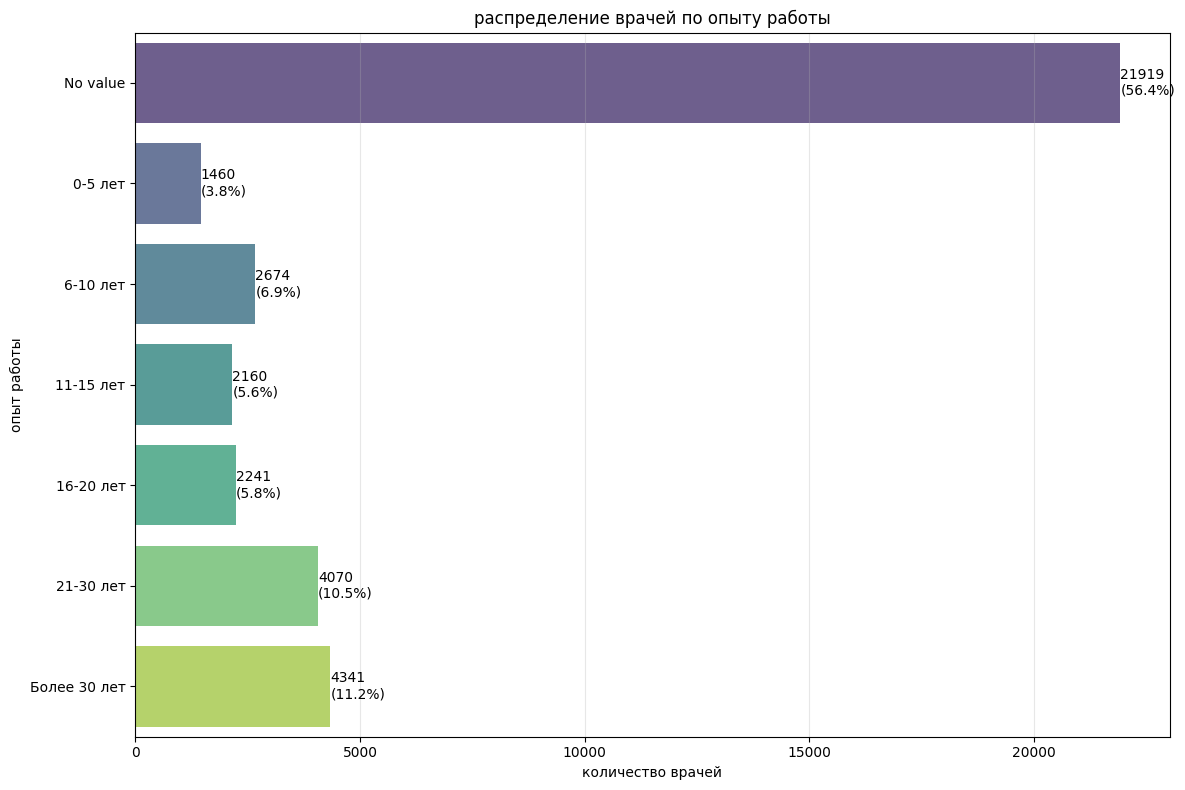

In [305]:
plt.figure(figsize=(12, 8))

ax = sns.countplot(data=doctors, y='experience_category', order=category_order, palette='viridis', alpha=0.8)

total = len(doctors)
for p in ax.patches:
    width = p.get_width()
    percentage = f'{100 * width / total:.1f}%'
    x = p.get_x() + width
    y = p.get_y() + p.get_height() / 2
    ax.annotate(f'{int(width)}\n({percentage})', (x, y), ha='left', va='center', fontsize=10)

plt.title('распределение врачей по опыту работы')
plt.xlabel('количество врачей')
plt.ylabel('опыт работы')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Видим, что больше половины значений пропущены. Восстановить их по другим показателям не представляется возможным. Посмотрим на распределение по квантилям и статистические показатели

In [306]:
doctors['experience'].describe()

,experience
count,16946.000000
mean,21.661159
std,12.634724
min,1.000000
25%,11.000000
50%,20.000000
75%,31.000000
max,71.000000


In [307]:
np.median(doctors[doctors.experience.notna()]['experience'])

np.float64(20.0)

In [308]:
stats.mode(doctors[doctors.experience.notna()]['experience'])

ModeResult(mode=np.float64(7.0), count=np.int64(671))

Видим, что по большей части врачи опытные (>10  лет опыта). Медиана практически сходится со средним значением. Значит данные сбалансированы, а выбросы не оказывают на них значимого влияния. Мода - 7 лет.

Text(0.5, 1.0, 'Experience KDE')

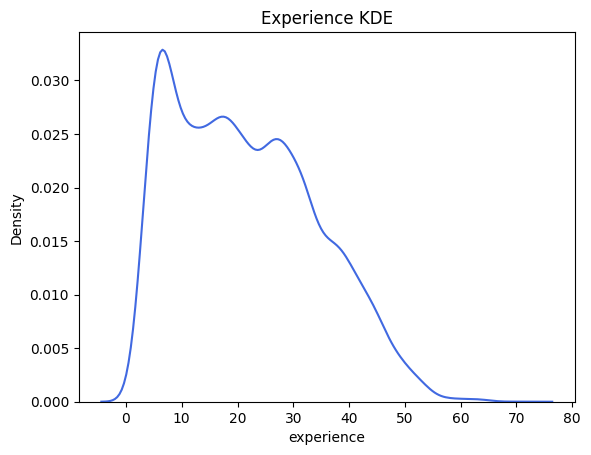

In [309]:
sns.kdeplot(doctors['experience'],color='royalblue')
plt.title("Experience KDE")

Видим пик плотности на опыте в 7 лет, затем интенсивность почти монотонно снижается. Возможно как-то связано с началом кризиса COVID-19 в 2020 году. Если исключить всплеск на этом участке, распределение можно было бы считать стремящимся к нормальному.

Ещё один пик - 16-19 лет. Совпадает с рекордным количеством обучающихся в ВУЗах России (2005-2010 годы). Третий пик на показателе 27-28 лет может быть связан с активным созданием новых университетов и развитием высшего образования в конце 1990-ых. [Источник данных.](https://rg.ru/2021/06/15/kolichestvo-rossiian-s-vysshim-obrazovaniem-prevysilo-31-procent.html)

Text(0.5, 1.0, 'Распределение показателя experience')

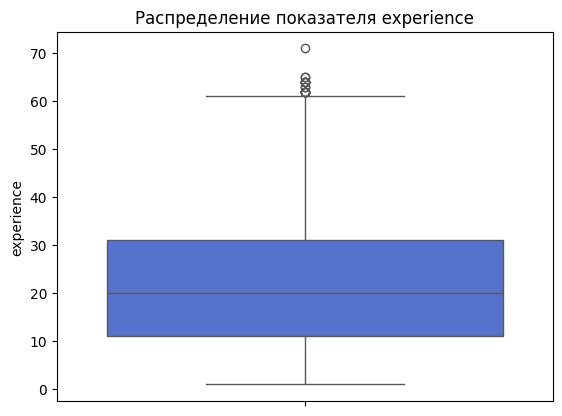

In [310]:
sns.boxplot(doctors['experience'],color='royalblue')
plt.title("Распределение показателя experience")

Минимум - 0 лет опыта, всё верно. Найдем верхние выбросы (выше конца уса / 3 IQR), если они есть.

In [311]:
q1 = doctors['experience'].quantile(0.25)
q3 = doctors['experience'].quantile(0.75)
iqr = q3 - q1

upper_whisker = q3 + 1.5 * iqr
upper_3iqr = q3 + 3 * iqr

print(upper_whisker, upper_3iqr, sep='\n')

61.0
91.0


Выше 3 IQR значений нет

In [312]:
doctors[doctors['experience'] > upper_3iqr].shape[0]

0

Выше верхнего уса 18 значений

In [313]:
doctors[doctors['experience'] > upper_whisker]['experience'].value_counts()

,count
experience,
62.0,7
64.0,6
63.0,2
65.0,2
71.0,1


Таким образом, врачи в пожилом возрасте с большим опытом также представлены на площадках

Можем сделать общий вывод, что по данному признаку много пропусков, однако данные распределены относительно симметрично и сбалансированно, выбросы не вносят большого вклада. Присутствует мультимодальность в виде трёх пиков, наибольший из них на показателе в 7 лет. В целом, если пренебречь структурными колебаниями, прослеживается тенденция нормального распределения.

/tmp/ipython-input-3485303716.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


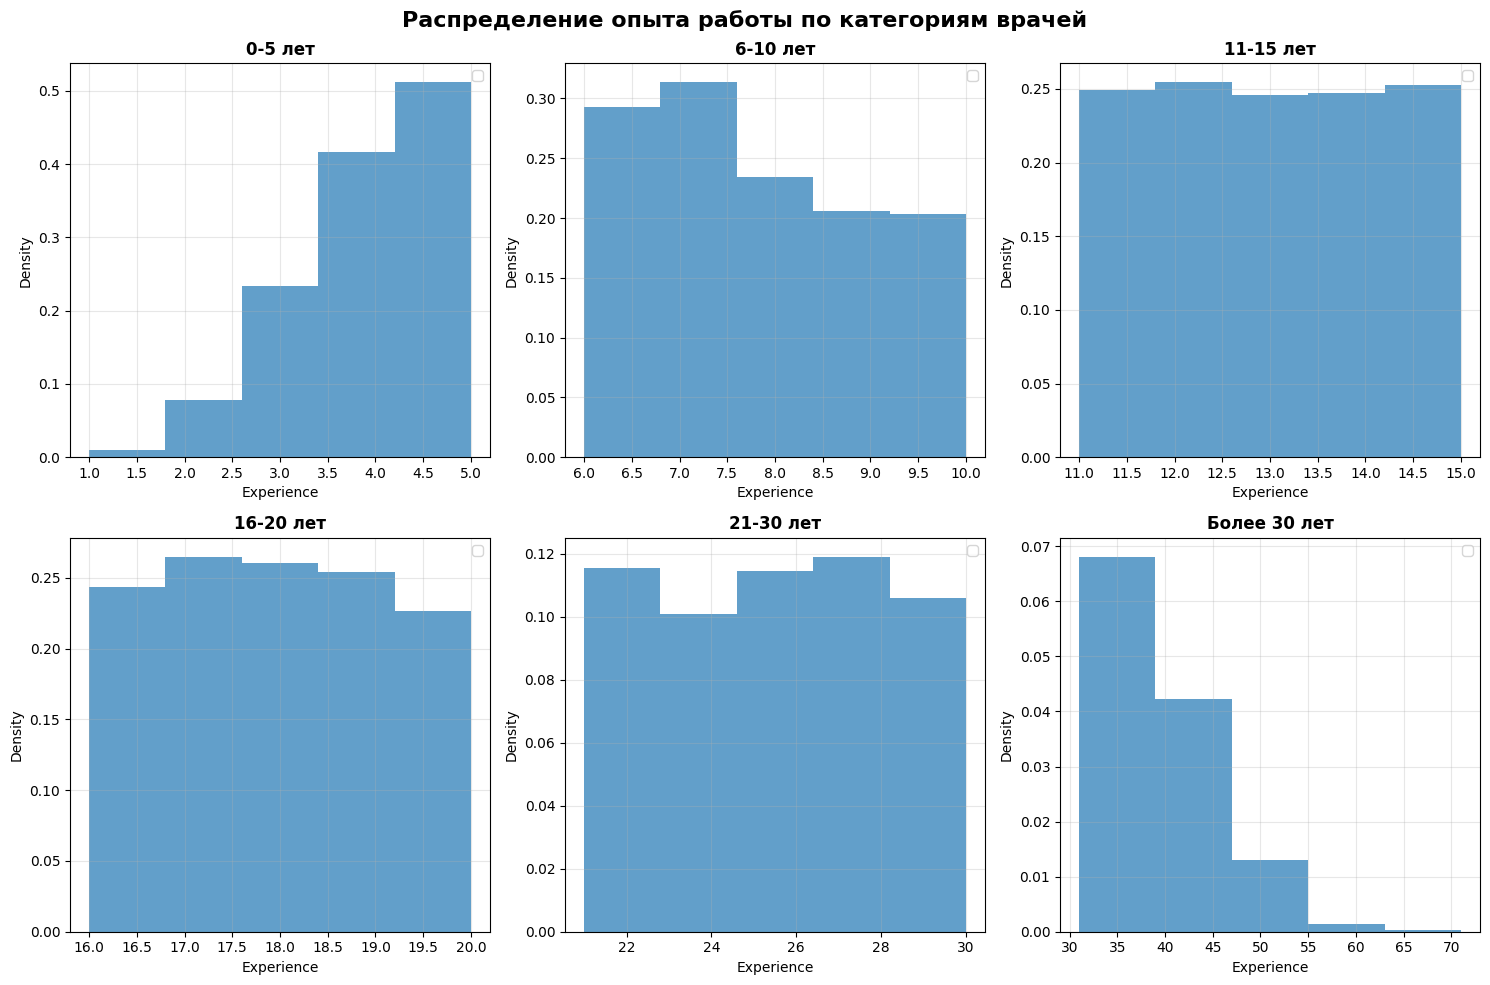

In [314]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Распределение опыта работы по категориям врачей', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.ravel()):
    category = category_order[idx+1]
    data = doctors[doctors.experience_category == category]['experience']

    hist = ax.hist(data, bins=5, alpha=0.7, density=True)

    ax.set_title(f'{category}', fontweight='bold')
    ax.set_xlabel('Experience')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend()


plt.tight_layout()
plt.show()

Видим сильную возрастающую тенденцию на категории 0-5 лет (выпуск врачей из ординатуры), небольшой спад после 7 лет (след от структурных изменений) и затем значительный спад после 30 лет (пенсия)

In [315]:
experienceAndPlatform = doctors.groupby('doctor_source')['experience'].agg(['mean','median','std','min','max'])
experienceAndPlatform

,mean,median,std,min,max
doctor_source,,,,,
ProDoctorov,21.664062,20.0,12.830587,2.0,62.0
SberHealth,24.975124,24.0,11.699332,3.0,61.0
Обе платформы,21.620717,20.0,12.638001,1.0,71.0


Врачи на сбере в среднем имеют чуть больше опыта

Распределение опыта работы на двух площадках

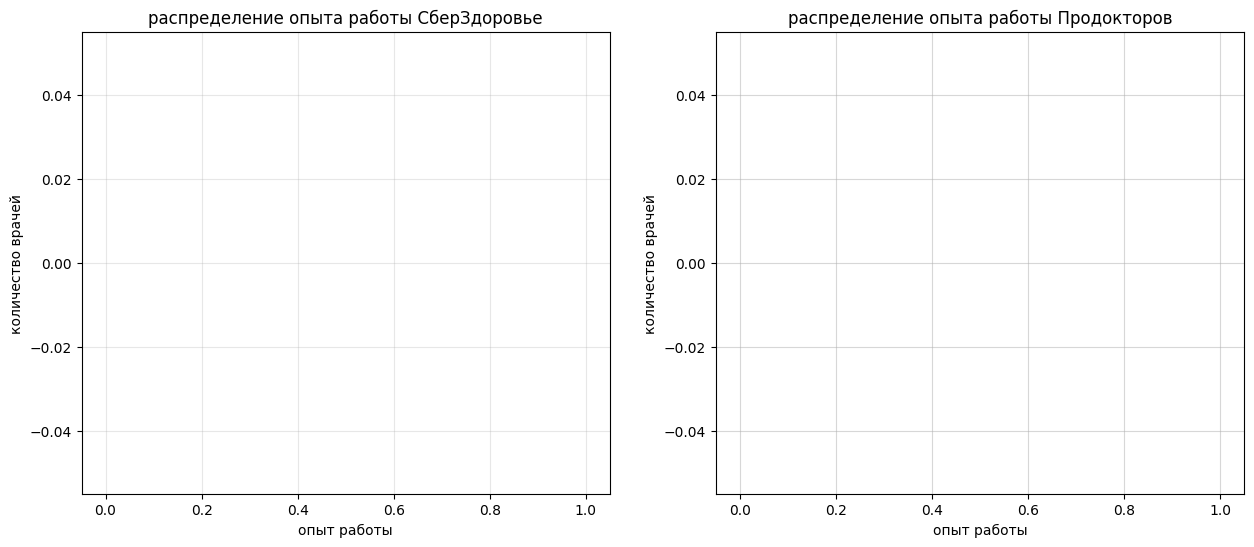

In [316]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(doctors[(doctors['doctor_source']=='СберЗдоровье')]['experience'],color='lightgreen')
axes[0].set_title('распределение опыта работы СберЗдоровье')
axes[0].set_xlabel('опыт работы')
axes[0].set_ylabel('количество врачей')
axes[0].grid(alpha=0.3)

axes[1].hist(doctors[doctors['doctor_source']=='Продокторов']['experience'],color='cornflowerblue')
axes[1].set_title('распределение опыта работы Продокторов')
axes[1].set_xlabel('опыт работы')
axes[1].set_ylabel('количество врачей')
axes[1].grid(alpha=0.5)

Сбер:
Распределение напоминает нормальное и смещено немного вправо и больше врачей со стажем от 15 до 30 лет.
Пик примерно на 20–25 годах опыта.

Продокторов:
Распределение чуть более равномерное в диапазоне до 30 лет.
Пик ближе к 10–20 годам опыта.

Вывод:
В среднем и по медиане врачи действительно немного опытнее (что подтверждает предыдущая таблица).
**У ProDoctorov больше врачей с меньшим опытом — вероятно,** там чаще регистрируются специалисты в начале карьеры.
Оба распределения широкие

#rating

In [317]:
doctors['rating_sber'].describe()

,rating_sber
count,31918.000000
mean,4.250658
std,0.497346
min,0.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


In [318]:
doctors['rating_prod'].describe()

,rating_prod
count,17214.000000
mean,2.557976
std,1.545650
min,0.000000
25%,1.500000
50%,2.500000
75%,3.900000
max,5.000000


распределение рейтингов SberHealth/ProDoctorov

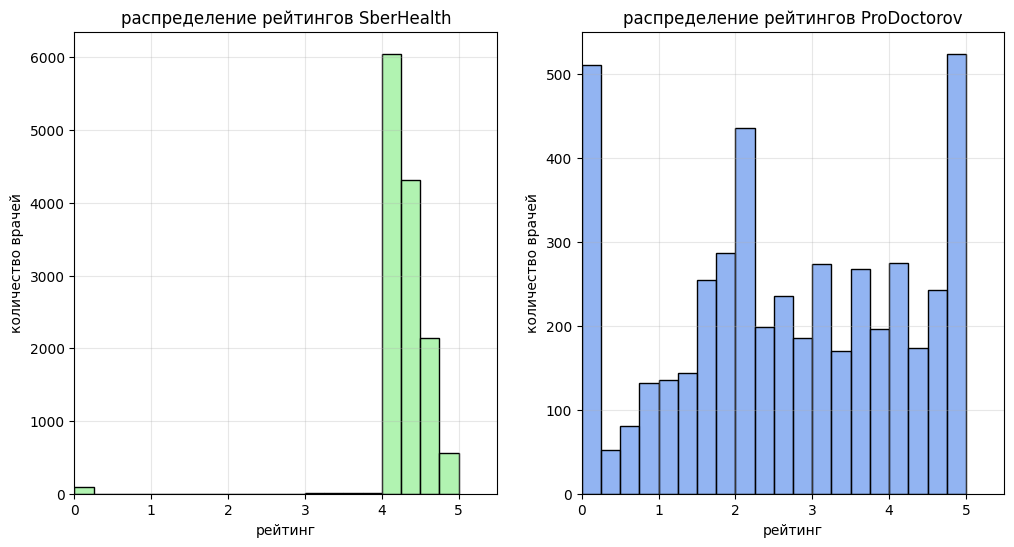

In [319]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sber_ratings = doctors[doctors['doctor_source'] == 'SberHealth']['rating_sber']
sns.histplot(sber_ratings, bins=20,alpha=0.7,color='lightgreen')
plt.title('распределение рейтингов SberHealth')
plt.xlabel('рейтинг')
plt.ylabel('количество врачей')
plt.xlim(0, 5.5)
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
sber_ratings = doctors[doctors['doctor_source'] == 'ProDoctorov']['rating_prod'].dropna()
sns.histplot(sber_ratings, bins=20,alpha=0.7,color='cornflowerblue')
plt.title('распределение рейтингов ProDoctorov')
plt.xlabel('рейтинг')
plt.ylabel('количество врачей')
plt.xlim(0, 5.5)
plt.grid(alpha=0.3)

где рейтинг выше

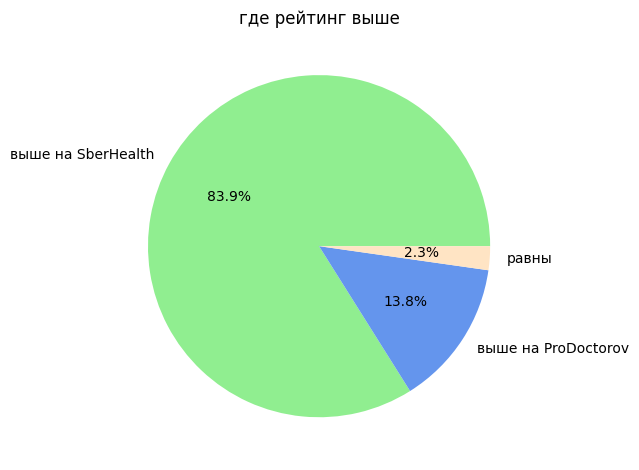

In [320]:
doctors_platforms_with_rating = doctors[
    (doctors['link_sber'].notna()) &
    (doctors['link_prod'].notna()) &
    (doctors['rating_sber'].notna()) &
    (doctors['rating_prod'].notna())].copy()

rating_diff = doctors_platforms_with_rating['rating_sber'] - doctors_platforms_with_rating['rating_prod']
higher_sber = (rating_diff > 0).sum()
higher_prod = (rating_diff < 0).sum()
equal = (rating_diff == 0).sum()

categories = ['выше на SberHealth', 'выше на ProDoctorov', 'равны']
values = [higher_sber, higher_prod, equal]
colors = ['lightgreen','cornflowerblue','bisque']
plt.pie(values, labels=categories, autopct='%1.1f%%',colors=colors)
plt.title('где рейтинг выше')

plt.tight_layout()
plt.show()

In [321]:
doctors['rating_prod'].corr(doctors['rating_sber'])

np.float64(0.05775264588526603)

corr оч низкая, никакая по факту

<Axes: xlabel='rating_prod', ylabel='rating_sber'>

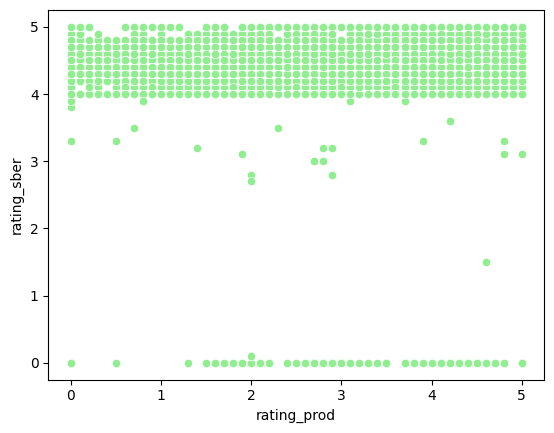

In [322]:
sns.scatterplot(data=doctors, x='rating_prod', y='rating_sber',color = 'lightgreen')

зависимость рейтинга от стажа по платформам

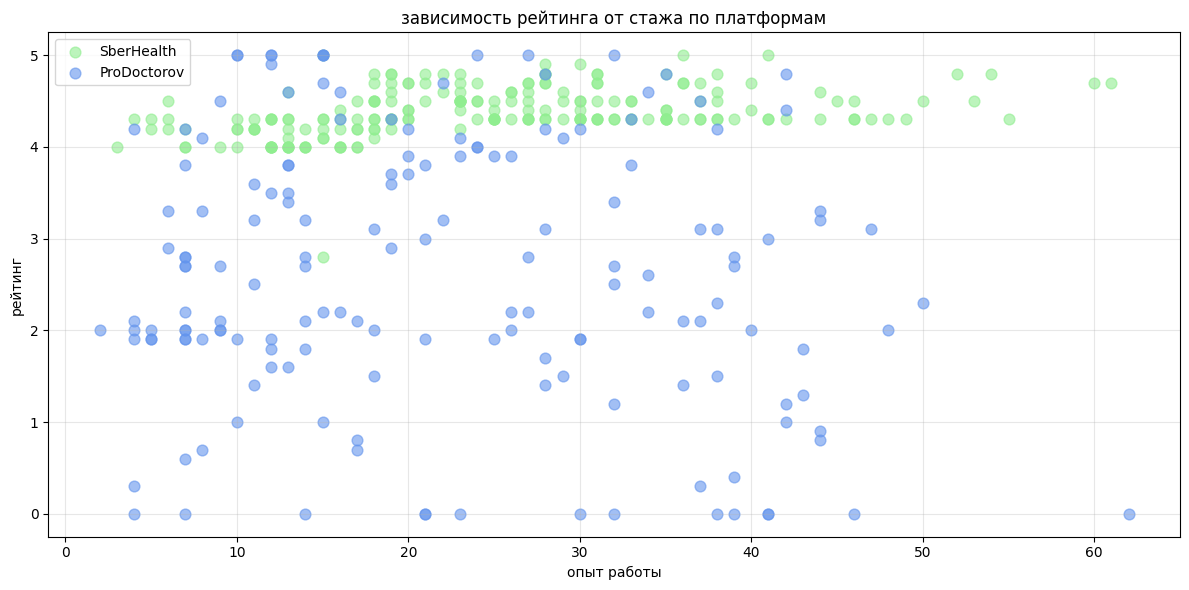

In [323]:
plt.figure(figsize=(12, 6))

plt.scatter(doctors[doctors['doctor_source']=='SberHealth']['experience'],
            doctors[doctors['doctor_source']=='SberHealth']['rating_sber'],alpha=0.6, color='lightgreen', s=60, label='SberHealth')

plt.scatter(doctors[doctors['doctor_source']=='ProDoctorov']['experience'],
            doctors[doctors['doctor_source']=='ProDoctorov']['rating_prod'],alpha=0.6, color='cornflowerblue', s=60, label='ProDoctorov')

plt.title('зависимость рейтинга от стажа по платформам')
plt.xlabel('опыт работы')
plt.ylabel('рейтинг')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [324]:
corr_sber = doctors[doctors['doctor_source']=='SberHealth']['experience'].corr(doctors[doctors['doctor_source']=='SberHealth']['rating_sber'])
corr_prod = doctors[doctors['doctor_source']=='ProDoctorov']['experience'].corr(doctors[doctors['doctor_source']=='ProDoctorov']['rating_prod'])
print(corr_sber,corr_prod)

0.4036837828320183 -0.12500897927172797


#Цена (`price`)

##основные характеристики

In [325]:
doctors[['price_sber', 'price_prod']].describe()

,price_sber,price_prod
count,4199.000000,5894.000000
mean,5010.827102,4698.710892
std,3932.463460,4039.904336
min,1000.000000,500.000000
25%,3000.000000,2800.000000
50%,3700.000000,3500.000000
75%,5500.000000,5400.000000
max,100000.000000,150000.000000


Основные характеристики цен на консультации врача на СберЗдоровье чуть выше, чем на ПроДокторов. Но не сильно, все равно виден схожий “массовый” уровень цен и  наличие выбросов

##выбросы

### sber

In [326]:
Q1 = doctors['price_sber'].quantile(0.25)
Q3 = doctors['price_sber'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
print(lower_whisker,upper_whisker)

-750.0 9250.0


<Axes: xlabel='price_sber'>

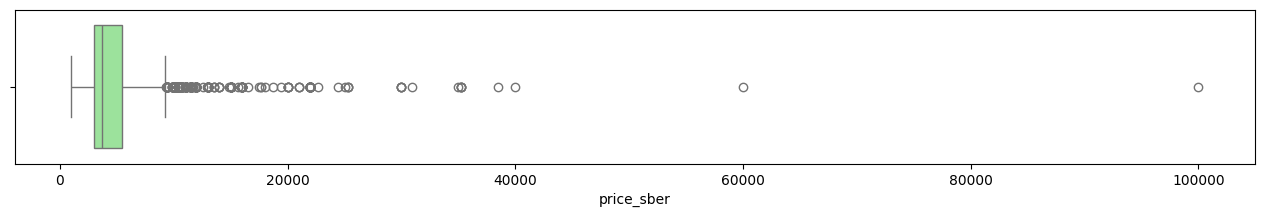

In [327]:
plt.figure(figsize=(16, 2))
sns.boxplot(data=doctors, x='price_sber',color = 'lightgreen')

рассмотрим без выбросов выше 3IQR

<Axes: xlabel='price_sber'>

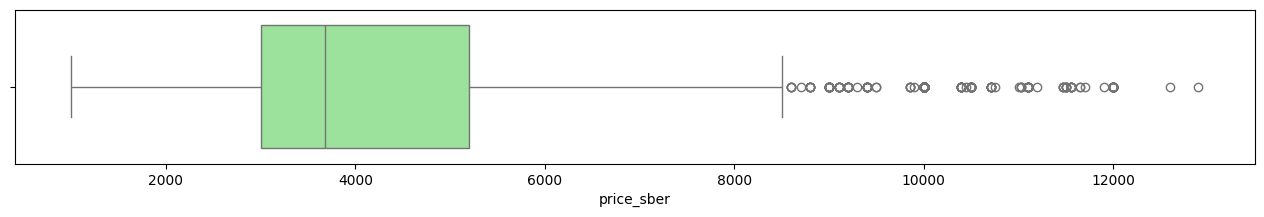

In [328]:
plt.figure(figsize=(16, 2))
sns.boxplot(data=doctors[doctors['price_sber'] < 3*IQR + Q3], x='price_sber',color='lightgreen')

Большинство цен лежат примерно в диапазоне 3000–5500

### prodoctorov

In [329]:
Q1 = doctors['price_prod'].quantile(0.25)
Q3 = doctors['price_prod'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
print(lower_whisker,upper_whisker)

-1100.0 9300.0


<Axes: xlabel='price_prod'>

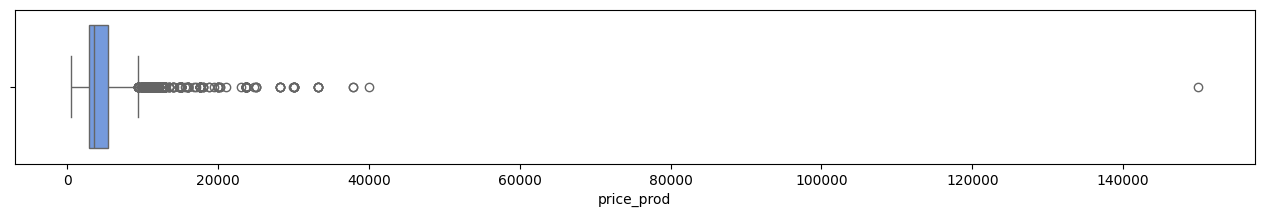

In [330]:
plt.figure(figsize=(16, 2))
sns.boxplot(data=doctors, x='price_prod', color='cornflowerblue')

аналогично рассмотрим значение < 3IQR

<Axes: xlabel='price_prod'>

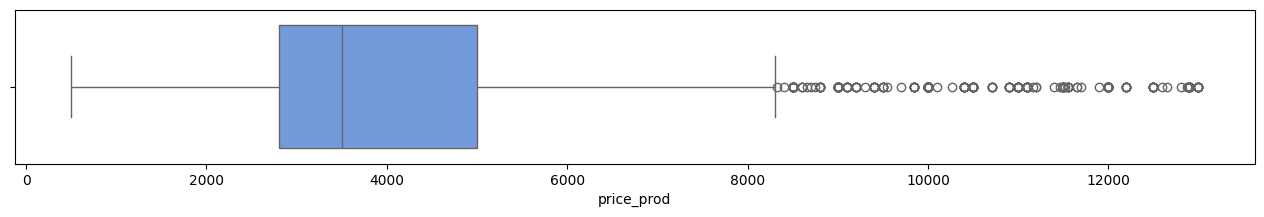

In [331]:
plt.figure(figsize=(16, 2))
sns.boxplot(data=doctors[doctors['price_prod'] < 3*IQR + Q3], x='price_prod',color='cornflowerblue')

Основной диапазон цен от 2800 до 5400 ₽, почти идентичен диапазону на Сбере 3000–5500.
Минимальные цены стартуют с 500, что говорит о наличии более дешёвых консультаций — возможно, молодых специалистов или скидок.

##cравнение цен для одних и тех же врачей на разных платформах

/tmp/ipython-input-4258261388.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


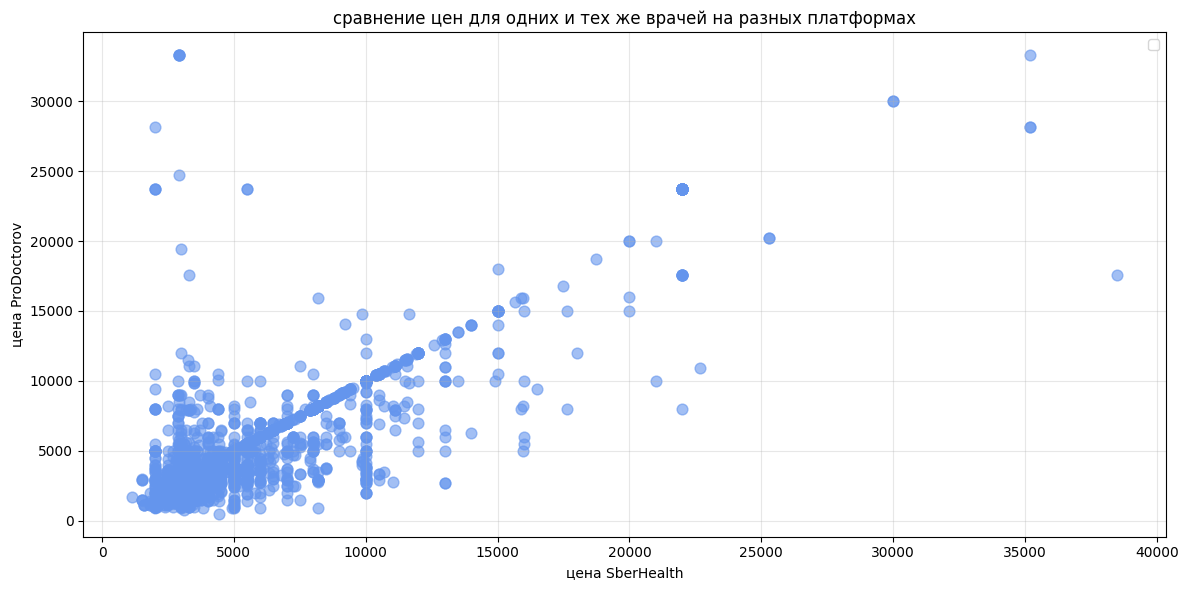

In [332]:
plt.figure(figsize=(12, 6))

doctors_platforms_with_price = doctors[
    (doctors['link_sber'].notna()) &
    (doctors['link_prod'].notna()) &
    (doctors['price_sber'].notna()) &
    (doctors['price_prod'].notna())]

plt.scatter(doctors_platforms_with_price['price_sber'], doctors_platforms_with_price ['price_prod'], alpha=0.6, color='cornflowerblue', s=60)
plt.title('cравнение цен для одних и тех же врачей на разных платформах')
plt.xlabel('цена SberHealth')
plt.ylabel('цена ProDoctorov')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Есть положительная зависимость, врачи сохраняют примерно одинаковый ценовой уровень на обеих площадках.

Но! Рассеивание большое
Видно множество точек, у которых цена на одной платформе выше, чем на другой. Часть врачей дифференцирует цены в зависимости от платформы — вероятно, по аудитории

In [333]:
corr = doctors_platforms_with_price['price_sber'].corr(doctors_platforms_with_price ['price_prod'])
corr

np.float64(0.7768772323962866)

цены и правда +- такие же, если, они, конечно, есть

##добавление столбца price

*у нас высокая корреляция у двух столбцов(никакой не является целевой переменной), тогда сделаем общий столбец

price = (price_sber+price_prod)/2*

In [334]:
doctors['price'] = (doctors['price_prod']+doctors['price_sber'])/2

In [335]:
doctors['price'].describe()

,price
count,2883.000000
mean,4855.611169
std,3394.128175
min,1360.000000
25%,2970.000000
50%,3700.000000
75%,5450.000000
max,34239.500000


In [336]:
Q1 = doctors['price'].quantile(0.25)
Q3 = doctors['price'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
print(lower_whisker,upper_whisker)

-750.0 9170.0


<Axes: xlabel='price'>

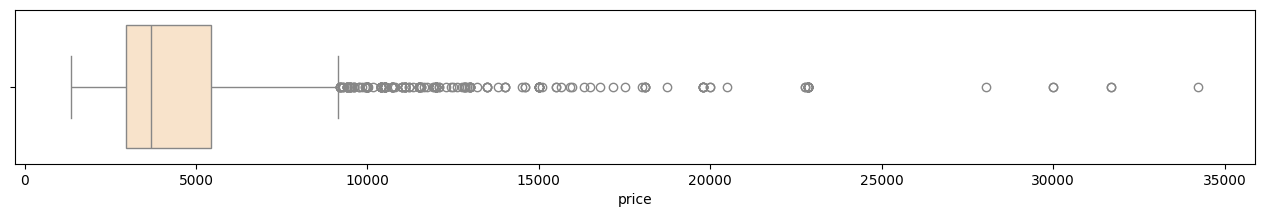

In [337]:
plt.figure(figsize=(16, 2))
sns.boxplot(data=doctors, x='price',color = 'bisque')

<Axes: xlabel='price'>

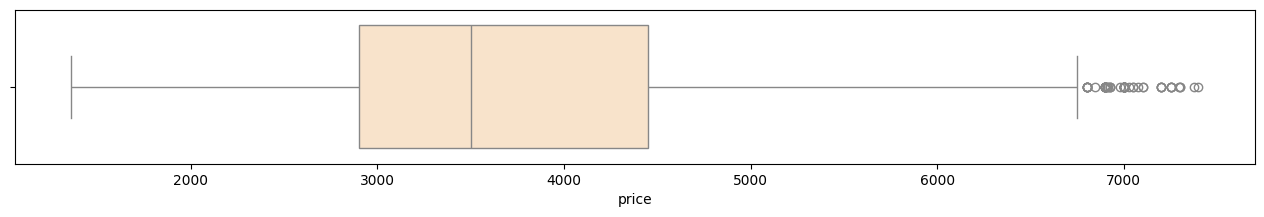

In [338]:
plt.figure(figsize=(16, 2))
sns.boxplot(data=doctors[doctors['price'] < 3*IQR], x='price',color = 'bisque')

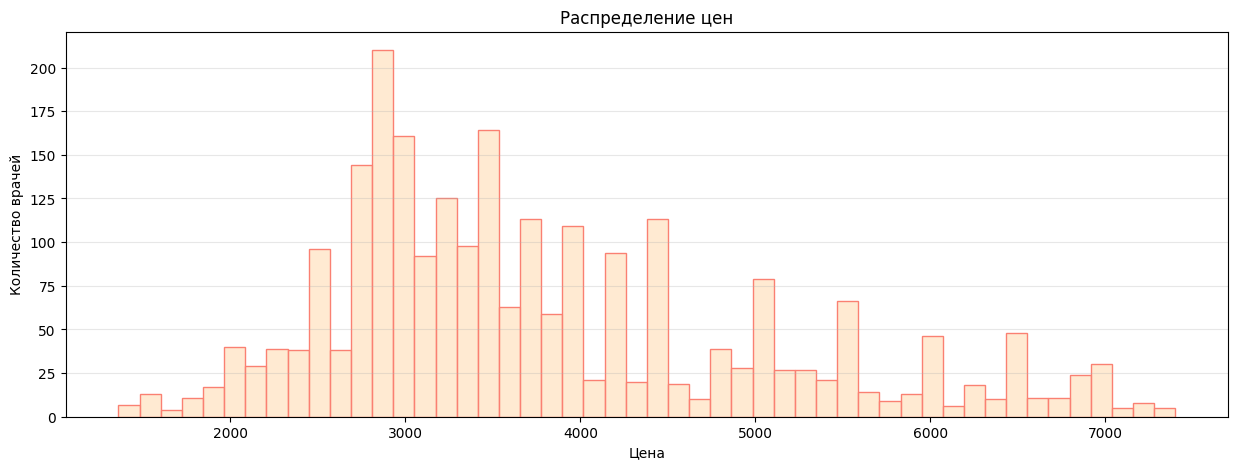

In [339]:
plt.figure(figsize=(15, 5))

sns.histplot(doctors[(doctors['price'].notna()) & (doctors['price'] < 3*IQR)]['price'],bins=50, color = 'bisque',edgecolor='salmon')
plt.title('Распределение цен')
plt.xlabel('Цена')
plt.ylabel('Количество врачей')
plt.grid(alpha=0.3,axis='y')

##распределения цен на платформах

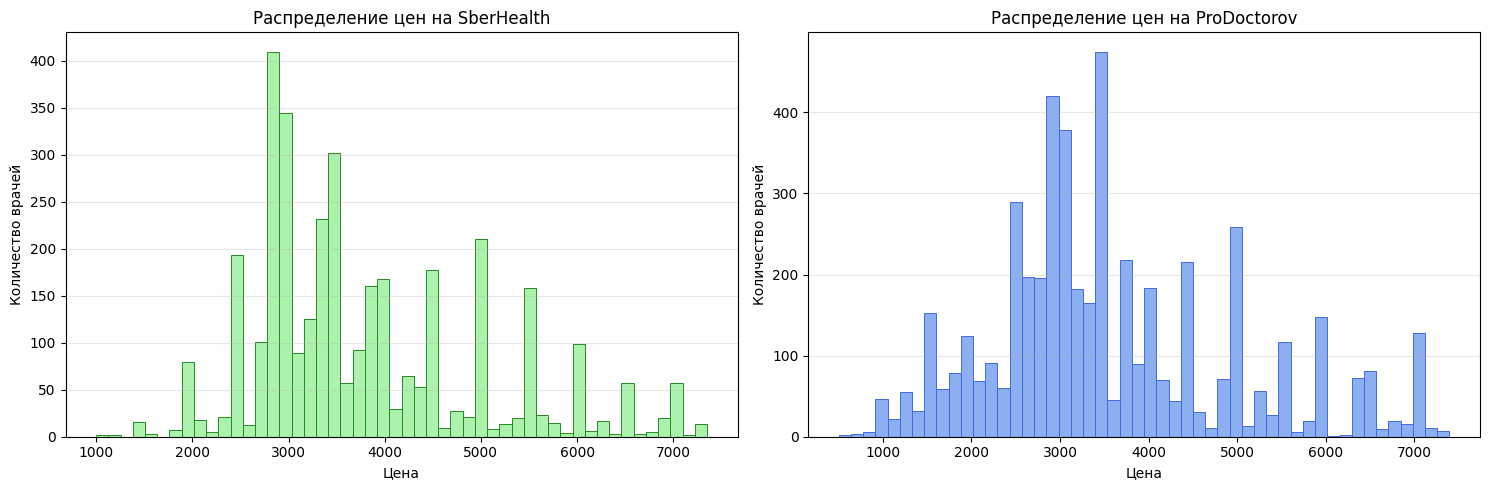

In [340]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(doctors[(doctors['price_sber'].notna()) & ((doctors['price_sber'] < 3*IQR))]['price_sber'],
             bins=50, color = 'lightgreen',edgecolor='forestgreen')
plt.title('Распределение цен на SberHealth')
plt.xlabel('Цена')
plt.ylabel('Количество врачей')
plt.grid(alpha=0.3,axis='y')

plt.subplot(1, 2, 2)
sns.histplot(doctors[(doctors['price_prod'].notna()) & (doctors['price_prod'] < 3*IQR)]['price_prod'],
             bins=50,color = 'cornflowerblue',edgecolor='royalblue')
plt.title('Распределение цен на ProDoctorov')
plt.xlabel('Цена')
plt.ylabel('Количество врачей')
plt.grid(alpha=0.3,axis='y')

plt.tight_layout()
plt.show()

##ценовые категории для sber, prodoctorov, AvgPrice

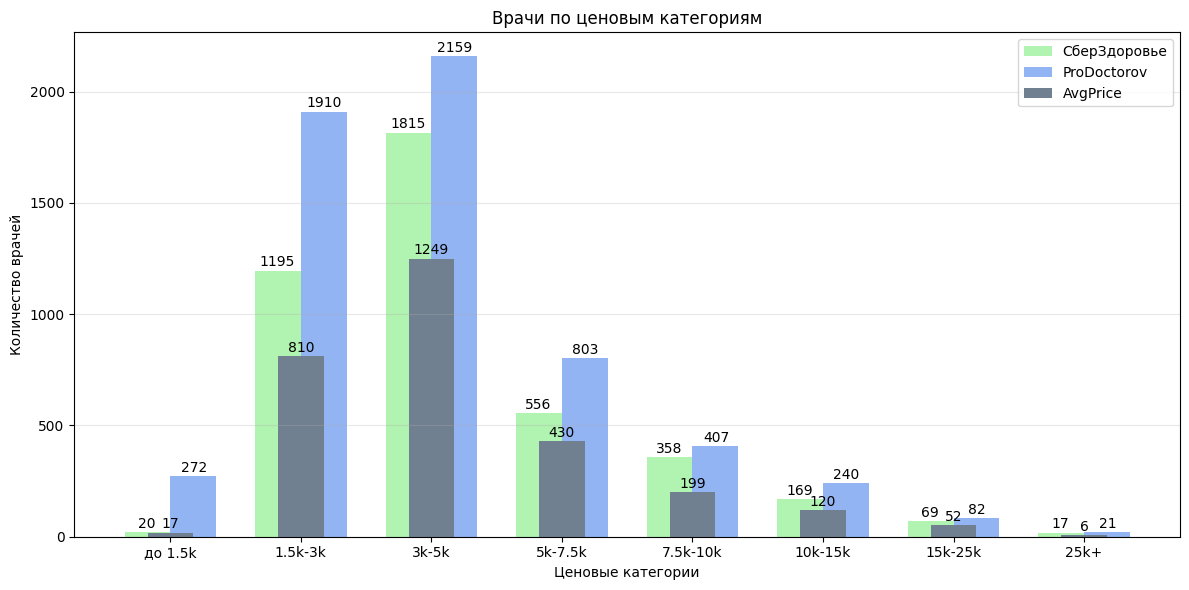

In [341]:
bins = [0, 1500, 3000, 5000, 7500, 10000, 15000, 25000, float('inf')]
labels = ['до 1.5k', '1.5k-3k', '3k-5k', '5k-7.5k', '7.5k-10k', '10k-15k', '15k-25k', '25k+']

doctors['price_category_sber'] = pd.cut(doctors['price_sber'], bins=bins, labels=labels)
doctors['price_category_prod'] = pd.cut(doctors['price_prod'], bins=bins, labels=labels)
doctors['price_category_avg'] = pd.cut(doctors['price'], bins=bins, labels=labels)

plt.figure(figsize=(12, 6))

sber_counts = doctors['price_category_sber'].value_counts().sort_index()
prod_counts = doctors['price_category_prod'].value_counts().sort_index()
price_counts = doctors['price_category_avg'].value_counts().sort_index()

x = np.arange(len(labels))
width = 0.35

bars1 = plt.bar(x - width/2, sber_counts, width, label='СберЗдоровье', alpha=0.7, color = 'lightgreen')
bars2 = plt.bar(x + width/2, prod_counts, width, label='ProDoctorov', alpha=0.7, color = 'cornflowerblue')
bars3 = plt.bar(x, price_counts, width, label='AvgPrice', color = 'slategrey')

for i, count in enumerate(sber_counts):
    plt.text(i-0.18, count + 20, str(count), ha='center')
for i, count in enumerate(prod_counts):
    plt.text(i+0.18, count + 20, str(count), ha='center')
for i, count in enumerate(price_counts):
    plt.text(i, count + 20, str(count), ha='center')

plt.xlabel('Ценовые категории')
plt.ylabel('Количество врачей')
plt.title('Врачи по ценовым категориям')
plt.xticks(x, labels)
plt.grid(alpha=0.3,axis='y')
plt.legend()
plt.tight_layout()
plt.show()


Основная масса рынка до 7.5k.

Больше 70 % врачей находятся в диапазоне 1.5k–5k

Категория 3k–5k ₽ — самая популярная:

Обе платформы наиболее насыщены врачами со средней ценой — конкуренция и выбор максимальны именно здесь.

Низкобюджетный сегмент почти отсутствует, что говорит о минимальном демпинге на рынке.

Дорогие приёмы редки — премиальный рынок ограничен, но вероятно ориентирован на центр города и узкие специальности

## зависимость цены от стажа по платформам

In [379]:
doctors[(doctors['doctor_source']=='SberHealth')][['experience','price_sber']].dropna().shape
doctors[(doctors['doctor_source']=='ProDoctorov')][['experience','price_prod']].dropna().shape


(71, 2)

у нас в датасете 71 врач у которых одновременно и опыт и цена указаны..

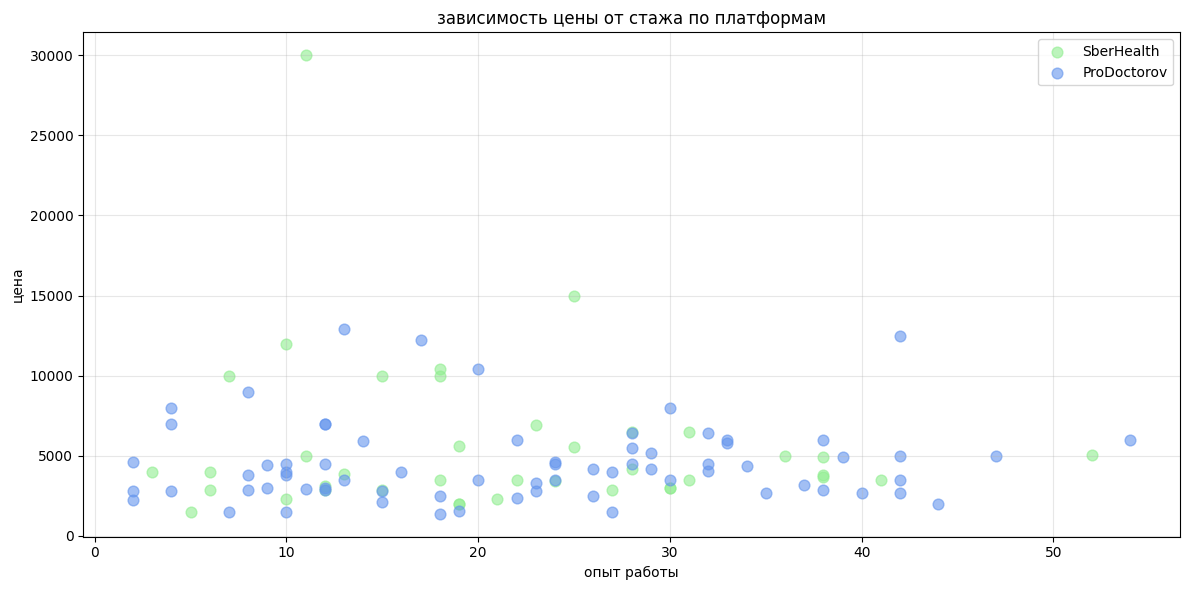

In [343]:
plt.figure(figsize=(12, 6))
plt.scatter(doctors[doctors['doctor_source']=='SberHealth']['experience'],
            doctors[doctors['doctor_source']=='SberHealth']['price_sber'], alpha=0.6, color='lightgreen', s=60, label='SberHealth')

plt.scatter(doctors[doctors['doctor_source']=='ProDoctorov']['experience'],
            doctors[doctors['doctor_source']=='ProDoctorov']['price_prod'], alpha=0.6, color='cornflowerblue', s=60, label='ProDoctorov')

plt.title('зависимость цены от стажа по платформам')
plt.xlabel('опыт работы')
plt.ylabel('цена')
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [344]:
corr_sber = doctors[doctors['doctor_source']=='SberHealth']['experience'].corr(doctors[doctors['doctor_source']=='SberHealth']['price_sber'])
corr_prod = doctors[doctors['doctor_source']=='ProDoctorov']['experience'].corr(doctors[doctors['doctor_source']=='ProDoctorov']['price_prod'])
print(corr_sber,corr_prod)

-0.1461417124172429 0.05292339083254625


## сравнение средних цен по специальностям на разных платформах

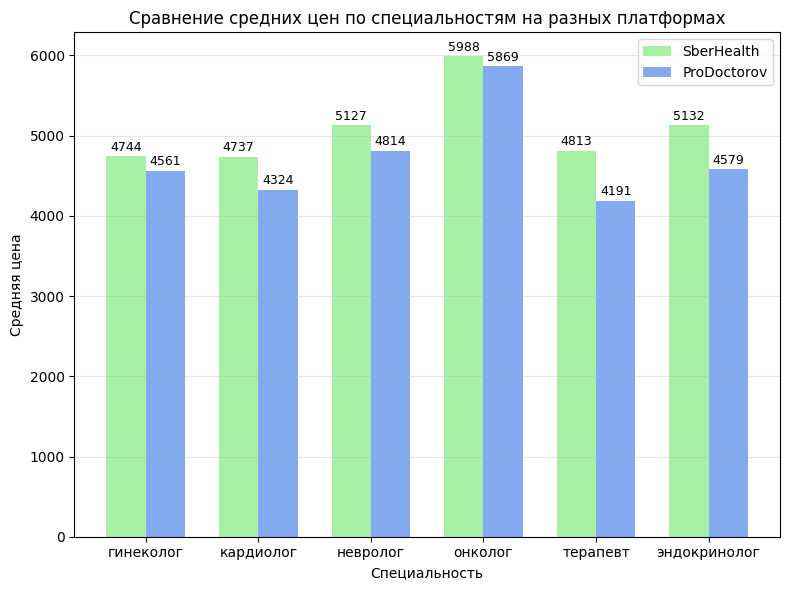

In [380]:
specialties = ['гинеколог', 'кардиолог', 'невролог', 'онколог', 'терапевт', 'эндокринолог']
avg_prices = pd.DataFrame(index=specialties, columns=['price_sber', 'price_prod'])

for specialty in specialties:
    specialty_doctors = doctors[doctors['speciality'].str.contains(specialty,na=False)]

    avg_sber = specialty_doctors['price_sber'].mean()
    avg_prices.loc[specialty, 'price_sber'] = avg_sber

    avg_prod = specialty_doctors['price_prod'].mean()
    avg_prices.loc[specialty, 'price_prod'] = avg_prod
avg_prices = avg_prices.astype(float)


plt.figure(figsize=(8, 6))
x = np.arange(len(specialties))
width = 0.35
plt.bar(x - width/2, avg_prices['price_sber'], width, label='SberHealth', alpha=0.8, color='lightgreen')
plt.bar(x + width/2, avg_prices['price_prod'], width, label='ProDoctorov', alpha=0.8, color='cornflowerblue')

plt.xlabel('Специальность')
plt.ylabel('Средняя цена')
plt.title('Сравнение средних цен по специальностям на разных платформах')
plt.xticks(x, specialties)
plt.legend()
plt.grid(axis='y', alpha=0.3)

for i in range(len(specialties)):
    sber_price = avg_prices['price_sber'].iloc[i]
    prod_price = avg_prices['price_prod'].iloc[i]
    plt.text(i - width/2, sber_price + 30, f'{sber_price:.0f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, prod_price + 30, f'{prod_price:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

СберЗдоровье дороже по всем специальностям


Онкологи — самые дорогие врачи на обеих платформах
Средняя цена около 6 000 ₽.
Редкая и высококвалифицированная категория, подтверждает премиум-сегмент.


Терапевты — самые доступные
На ПроДокторов — около 4 200 ₽, что на 30% ниже, чем у онкологов.


Разница между платформами стабильна по всем направлениям

## посмотрим на разницы в ценах:

In [346]:
price_diff = doctors_platforms_with_price['price_sber'] - doctors_platforms_with_price['price_prod']
price_diff.describe()

,0
count,2883.000000
mean,325.271592
std,2409.271925
min,-30379.000000
25%,0.000000
50%,0.000000
75%,885.000000
max,20900.000000


In [347]:
doctors_with_price_diff = doctors.copy()
doctors_with_price_diff['price_diff'] = abs(doctors_platforms_with_price['price_sber'] - doctors_platforms_with_price['price_prod']) # по модулю
doctors_with_price_diff['price_diff'].describe()

,price_diff
count,2883.000000
mean,1024.759625
std,2204.525541
min,0.000000
25%,0.000000
50%,210.000000
75%,1250.000000
max,30379.000000


среднее очень отличается от медианы

<Axes: xlabel='price_diff'>

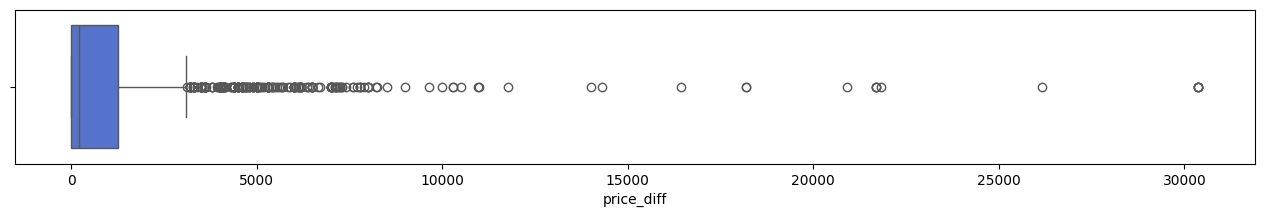

In [348]:
plt.figure(figsize=(16, 2))
sns.boxplot(data=doctors_with_price_diff, x='price_diff',color='royalblue')

<Axes: xlabel='price_diff', ylabel='Count'>

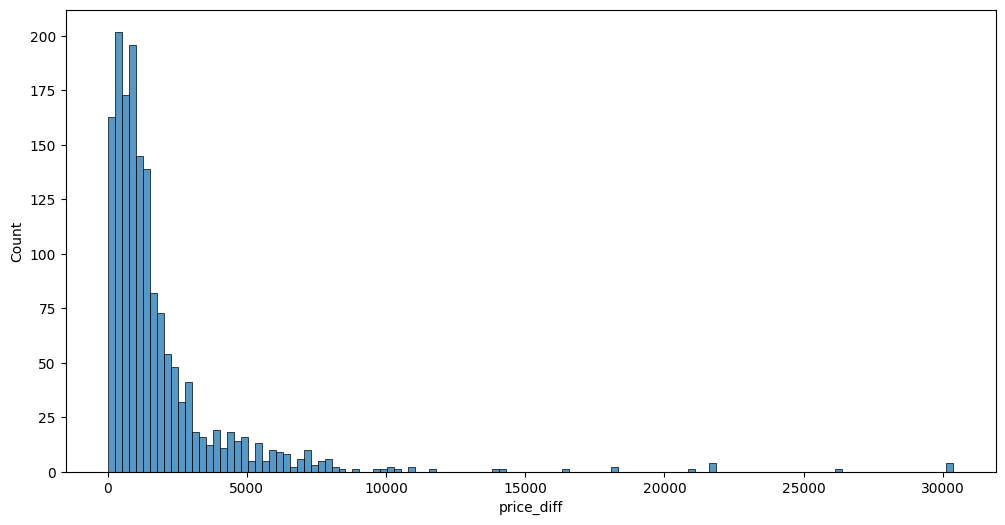

In [387]:
plt.figure(figsize=(12, 6))
sns.histplot(data=doctors_with_price_diff[doctors_with_price_diff['price_diff'] > 0], x='price_diff')

(0.0, 5695.4)

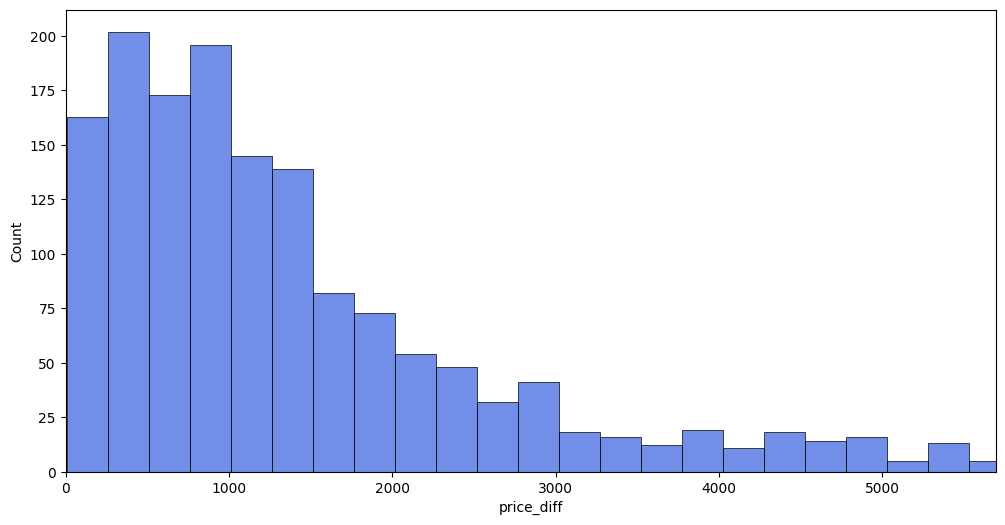

In [388]:
plt.figure(figsize=(12, 6))
sns.histplot(data=doctors_with_price_diff[doctors_with_price_diff['price_diff'] > 0], x='price_diff',color='royalblue')
plt.xlim(0, doctors_with_price_diff['price_diff'].quantile(0.97))

Пик в диапазоне 0–1000 ₽ — значит, у большинства врачей расхождение между Сбером и ПроДоктором минимальное, хвост доходит до 5–6 тыс., что всё ещё заметная разница. Распределение остается скошенным

Очень много выбросов. Оценим по верхнему усу и 3 IQR

In [351]:
q1 = doctors_with_price_diff['price_diff'].quantile(0.25)
q3 = doctors_with_price_diff['price_diff'].quantile(0.75)
iqr = q3 - q1

upper_whisker = q3 + 1.5 * iqr
upper_3iqr = q3 + 3 * iqr

print(upper_whisker, upper_3iqr, sep='\n')

3125.0
5000.0


In [352]:
doctors_with_price_diff[doctors_with_price_diff['price_diff'] > upper_whisker].shape[0]

226

In [353]:
doctors_with_price_diff[doctors_with_price_diff['price_diff'] > upper_3iqr].shape[0]

109

Посмотрим на те, где выбросы больше 3 IQR

In [354]:
doctors_with_price_diff[doctors_with_price_diff['price_diff'] > upper_3iqr][['price_sber', 'price_prod', 'price_diff']]

,price_sber,price_prod,price_diff
503,10000.0,2000.0,8000.0
504,10000.0,2000.0,8000.0
859,10000.0,2900.0,7100.0
1466,10000.0,3500.0,6500.0
2262,7000.0,1500.0,5500.0
...,...,...,...
36085,9850.0,4000.0,5850.0
37168,13000.0,5000.0,8000.0
37600,8190.0,2900.0,5290.0
37846,2870.0,10000.0,7130.0


In [355]:
doctors_with_price_diff[doctors_with_price_diff['price_diff'] > upper_3iqr][['price_sber', 'price_prod', 'price_diff']].describe()

,price_sber,price_prod,price_diff
count,109.000000,109.000000,109.000000
mean,9263.623853,9155.880734,8988.495413
std,7082.812460,8134.315486,5954.838382
min,2000.000000,900.000000,5060.000000
25%,3300.000000,3000.000000,6000.000000
50%,9850.000000,8000.000000,7000.000000
75%,10500.000000,10100.000000,8000.000000
max,38500.000000,33279.000000,30379.000000


В этих случаях в осеовном выше на сбере

In [356]:
doctors_with_price_diff[doctors_with_price_diff['price_diff'] > q3 + 9*iqr][['price_sber', 'price_prod', 'price_diff']]

,price_sber,price_prod,price_diff
5228,2900.0,33279.0,30379.0
6396,2900.0,33279.0,30379.0
8554,5500.0,23694.0,18194.0
10288,2000.0,23694.0,21694.0
10954,5500.0,23694.0,18194.0
11580,22000.0,8000.0,14000.0
12858,2900.0,33279.0,30379.0
16167,3000.0,19425.0,16425.0
16729,3300.0,17600.0,14300.0
19934,2900.0,33279.0,30379.0


Для самых высоких значений разниц цен - очень высокие цены на Продокторов, в 13 из 15 случаев (отклонения выше 9 IQR)

## где цена выше для одних и тех же враче

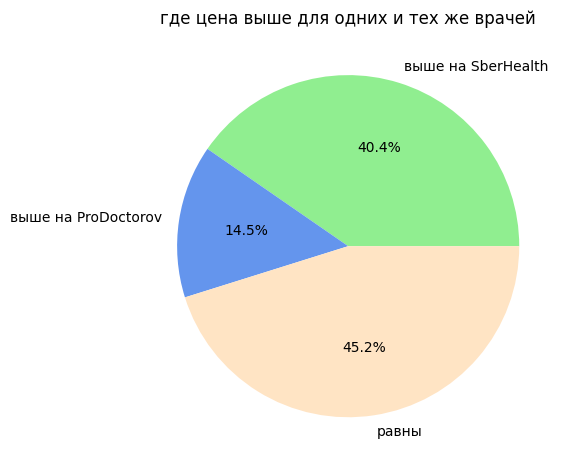

In [357]:
higher_sber = (price_diff > 0).sum()
higher_prod = (price_diff < 0).sum()
equal = (price_diff == 0).sum()

categories = ['выше на SberHealth', 'выше на ProDoctorov', 'равны']
values = [higher_sber, higher_prod, equal]
colors = ['lightgreen','cornflowerblue','bisque']
plt.pie(values, labels=categories, autopct='%1.1f%%',colors=colors)
plt.title('где цена выше для одних и тех же врачей')

plt.tight_layout()
plt.show()

In [358]:
corr = doctors_platforms_with_price['price_sber'].corr(doctors_platforms_with_price['price_prod'])
corr

np.float64(0.7768772323962866)

#Специальности (`'speciality'`)

In [359]:
doctors.columns

Index(['name', 'experience', 'rating_sber', 'review_count_sber', 'price_sber',
       'link_sber', 'clinics_count_sber', 'clinic_1_name_sber',
       'clinic_1_address_sber', 'clinic_1_metro_sber', 'clinic_2_name_sber',
       'clinic_2_address_sber', 'clinic_2_metro_sber', 'clinic_3_name_sber',
       'clinic_3_address_sber', 'clinic_3_metro_sber', 'link_prod',
       'price_prod', 'rating_prod', 'review_count_prod', 'clinics_count_prod',
       'clinic_1_name_prod', 'clinic_1_address_prod', 'clinic_1_metro_prod',
       'clinic_2_name_prod', 'clinic_2_address_prod', 'clinic_2_metro_prod',
       'clinic_3_name_prod', 'clinic_3_address_prod', 'clinic_3_metro_prod',
       'speciality', 'is_kids', 'is_adults', 'doctor_source',
       'experience_category', 'price', 'price_category_sber',
       'price_category_prod', 'price_category_avg'],
      dtype='object')

In [360]:
def speciality_to_string(spec_list):
    if pd.isna(spec_list):
        return None
    if isinstance(spec_list, str):
        try:
            spec_list = eval(spec_list)
        except:
            return spec_list
    if isinstance(spec_list, list):
        return ', '.join(spec_list)
    return str(spec_list)
doctors['speciality'] = doctors['speciality'].apply(speciality_to_string)

In [361]:
doctors['speciality']

,speciality
0,терапевт
1,терапевт
2,None
3,None
4,None
...,...
38860,"акушер, детский гинеколог, гинеколог"
38861,"реабилитолог, невролог"
38862,"остеопат, терапевт"
38863,"акушер, гинеколог-хирург, гинеколог"


In [362]:
doctors['speciality'].unique()

array(['терапевт', None,
       'детский невролог, детский эпилептолог, невролог', ...,
       'функциональный диагност, детский невролог, детский эпилептолог',
       'аллерголог, детский пульмонолог, функциональный диагност, терапевт, пульмонолог',
       'акушер, онколог-гинеколог, гинеколог-эндокринолог, врач узи, нутрициолог, репродуктолог, диетолог, гинеколог'],
      dtype=object)

In [363]:
all_individual_specs = []
for spec_str in doctors['speciality'].dropna():
    specs = spec_str.split(', ')
    all_individual_specs.extend(specs)

individual_spec_counts = pd.Series(all_individual_specs).value_counts()

In [364]:
individual_spec_counts.sample(10)

,count
детский психолог,4
подолог-эстетист,1
педиатр,150
перинатолог,2
детский генетик,2
массажист,6
клинический фармаколог,10
хирург-ортопед,1
детский врач-косметолог,4
хирург-эндокринолог,24


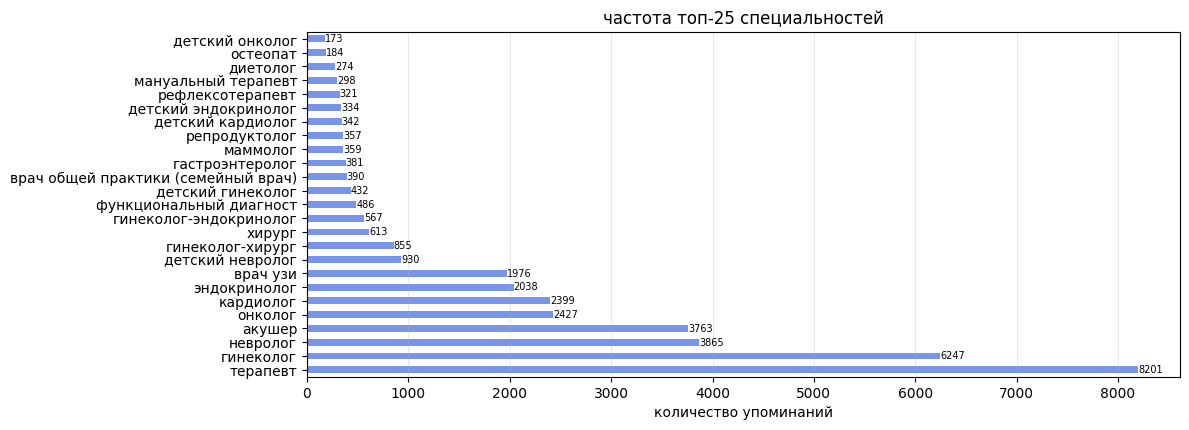

In [365]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
top_25_specs = individual_spec_counts.head(25)
top_25_specs.plot(kind='barh', alpha=0.7,color='royalblue')
plt.title('частота топ-25 специальностей')
plt.xlabel('количество упоминаний')
plt.grid(axis='x', alpha=0.3)

for i, count in enumerate(top_25_specs.values):
    plt.text(count, i, str(count), va='center', fontsize=7)

plt.tight_layout()
plt.show()

## популярные специальности среди терапевтов

In [389]:
terapevts = doctors[doctors['speciality'].str.contains('терапевт', case=False, na=False)]

terapevt_individual_specs = []
for spec_str in terapevts['speciality'].dropna():
    specs = spec_str.split(', ')
    terapevt_individual_specs.extend(specs)

terapevt_spec_counts = pd.Series(terapevt_individual_specs).value_counts()

In [392]:
terapevt_spec_counts.head(20)

,count
терапевт,8201
невролог,600
кардиолог,569
гастроэнтеролог,375
врач общей практики (семейный врач),362
рефлексотерапевт,321
мануальный терапевт,298
врач узи,174
функциональный диагност,159
онколог,159


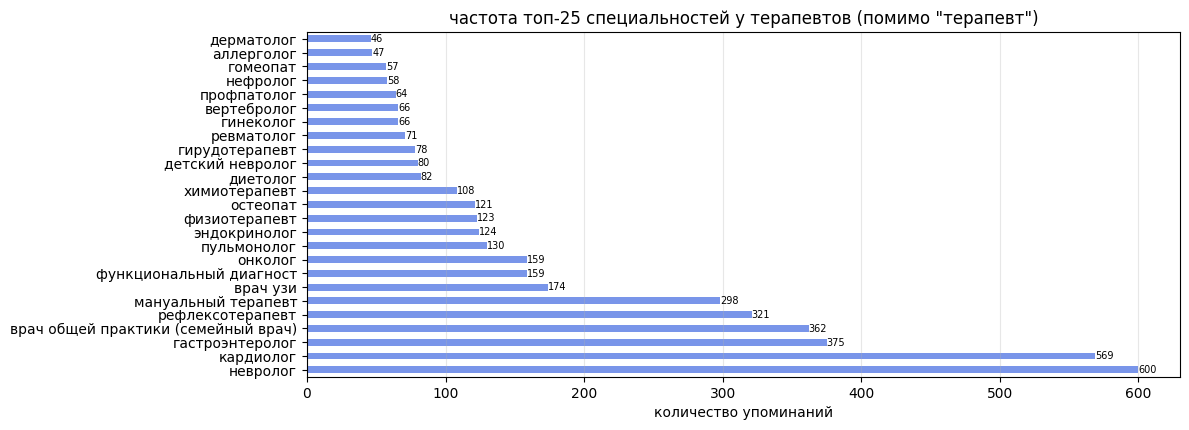

In [368]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
top_25_specs = terapevt_spec_counts[1:26]
top_25_specs.plot(kind='barh', alpha=0.7,color='royalblue')
plt.title('частота топ-25 специальностей у терапевтов (помимо "терапевт")')
plt.xlabel('количество упоминаний')
plt.grid(axis='x', alpha=0.3)

for i, count in enumerate(top_25_specs.values):
    plt.text(count, i, str(count), va='center', fontsize=7)

plt.tight_layout()
plt.show()

#Детские и взрослые врачи (`kids/adults`)

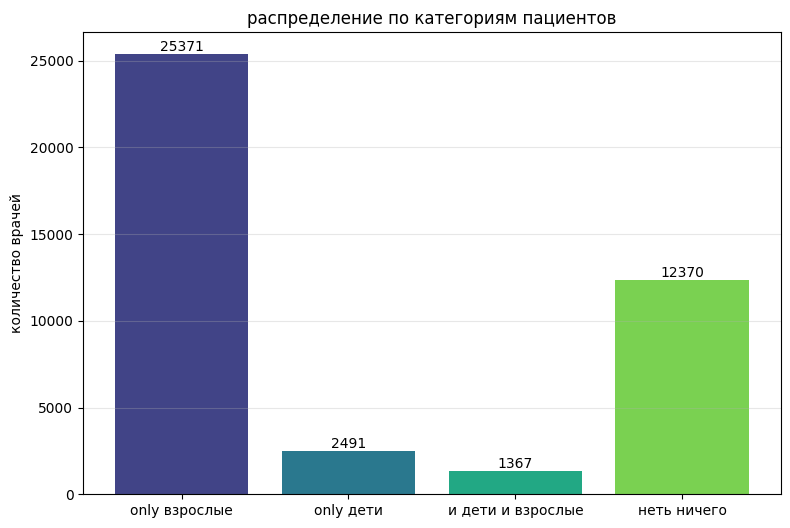

In [369]:
plt.figure(figsize=(9, 6))

categories_count = {
    'only взрослые': doctors['is_adults'].sum(),
    'only дети': doctors['is_kids'].sum(),
    'и дети и взрослые': ((doctors['is_adults'] == True) & (doctors['is_kids'] == True)).sum(),
    'неть ничего': ((doctors['is_adults'] == False) & (doctors['is_kids'] == False)).sum()}

colors = sns.color_palette("viridis", len(categories_count))
plt.bar(categories_count.keys(), categories_count.values(),color=colors)
plt.title('распределение по категориям пациентов')
plt.ylabel('количество врачей')
plt.grid(axis='y', alpha=0.3)

for i, count in enumerate(categories_count.values()):
    plt.text(i, count, str(count), ha='center', va='bottom')

#Метро (`metro`)

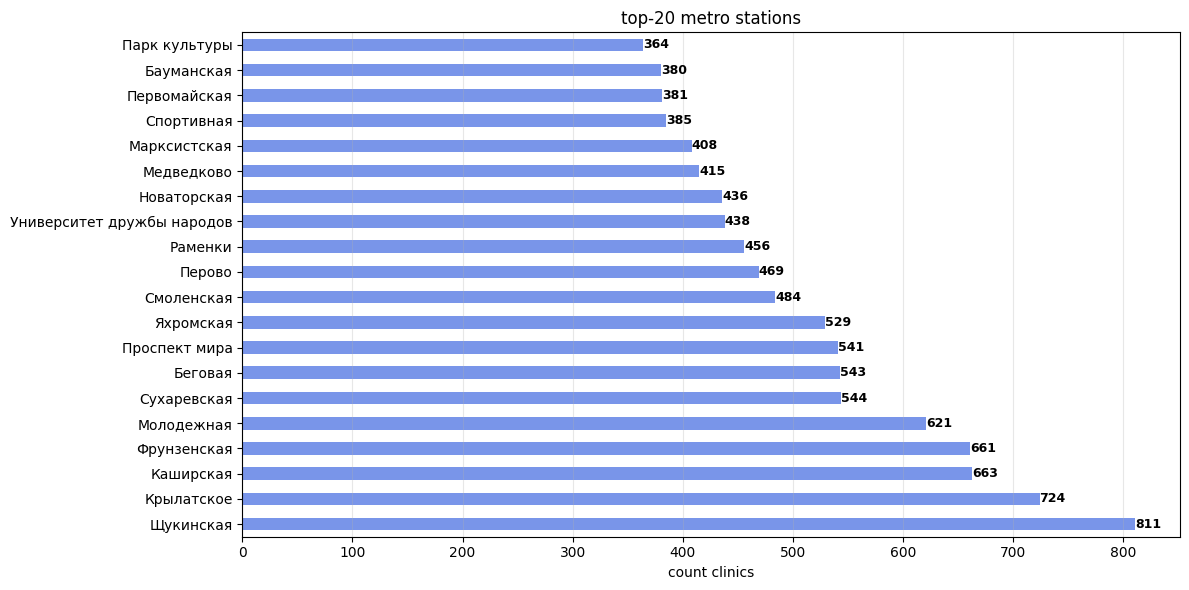

In [393]:
plt.figure(figsize=(12,6))

all_metro_stations = []
metro_columns = [col for col in doctors.columns if 'metro' in col]
for col in metro_columns:
    metro_data = doctors[col].dropna()
    all_metro_stations.extend(metro_data)

metro_counts = pd.Series(all_metro_stations).value_counts()
top_20_metro = metro_counts.head(20)
top_20_metro.plot(kind='barh', color='royalblue', alpha=0.7)
plt.title('top-20 metro stations')
plt.xlabel('count clinics')
plt.grid(axis='x', alpha=0.3)

for i, count in enumerate(top_20_metro.values):
    plt.text(count, i, str(count), va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [371]:
metro_counts

,count
Щукинская,811
Крылатское,724
Каширская,663
Фрунзенская,661
Молодежная,621
...,...
Звёздная,1
Кремлёвская,1
Площадь 1905 года,1
Козья слобода,1


# Число клиник (clinics_count)

In [372]:
int(doctors['clinics_count_sber'].max())

8

In [374]:
doctors['clinics_count_sber'].value_counts()

,count
clinics_count_sber,
0.0,27559
1.0,3492
2.0,726
3.0,115
4.0,16
5.0,10
8.0,1


In [375]:
doctors['clinics_count_prod'].value_counts()

,count
clinics_count_prod,
1.0,16986
2.0,6057
3.0,1881
4.0,497
5.0,158
6.0,57
7.0,11
9.0,4
8.0,4


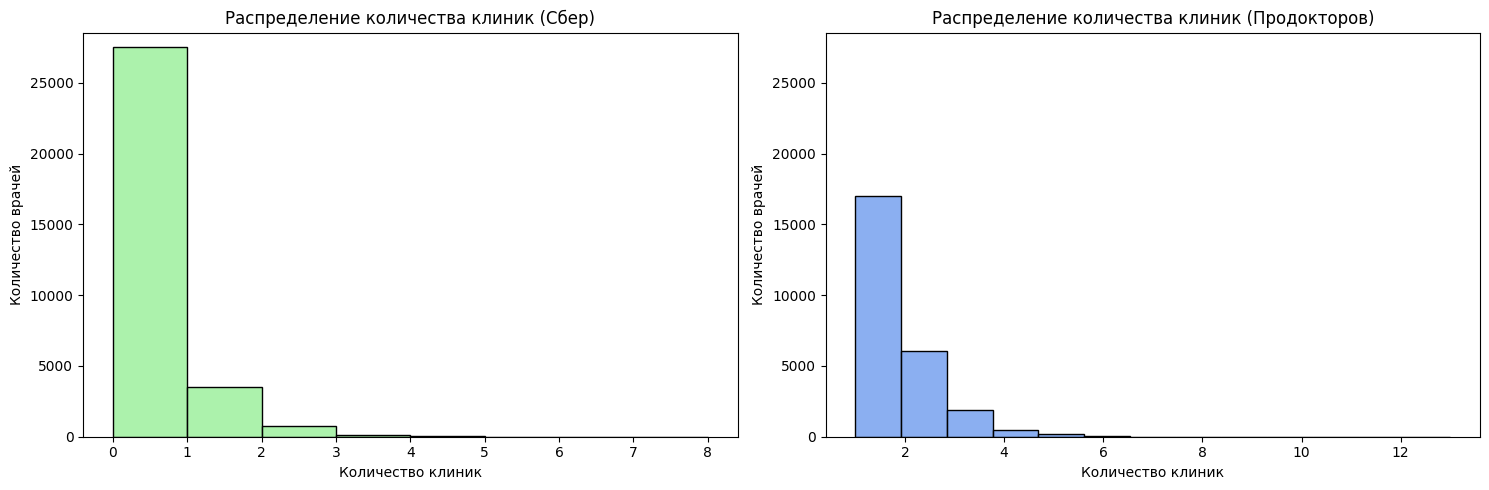

In [394]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax1, ax2 = axes

sns.histplot(data=doctors, x='clinics_count_sber', bins=int(doctors['clinics_count_sber'].max()), ax=ax1,color = 'lightgreen')
ax1.set_title('Распределение количества клиник (Сбер)')
ax1.set_xlabel('Количество клиник')
ax1.set_ylabel('Количество врачей')
ax1.set_ylim(0, 27559+1000)

sns.histplot(data=doctors, x='clinics_count_prod', bins=int(doctors['clinics_count_prod'].max()), ax=ax2,color = 'cornflowerblue')
ax2.set_title('Распределение количества клиник (Продокторов)')
ax2.set_xlabel('Количество клиник')
ax2.set_ylabel('Количество врачей')
ax2.set_ylim(0, 27559+1000)

plt.tight_layout()
plt.show()

In [395]:
doctors['clinics_count_prod'].value_counts()

,count
clinics_count_prod,
1.0,16986
2.0,6057
3.0,1881
4.0,497
5.0,158
6.0,57
7.0,11
9.0,4
8.0,4


На Продокторов чаще есть информация о клиниках

#Корреляция всех числовых признаков (Heatmap)

<Axes: >

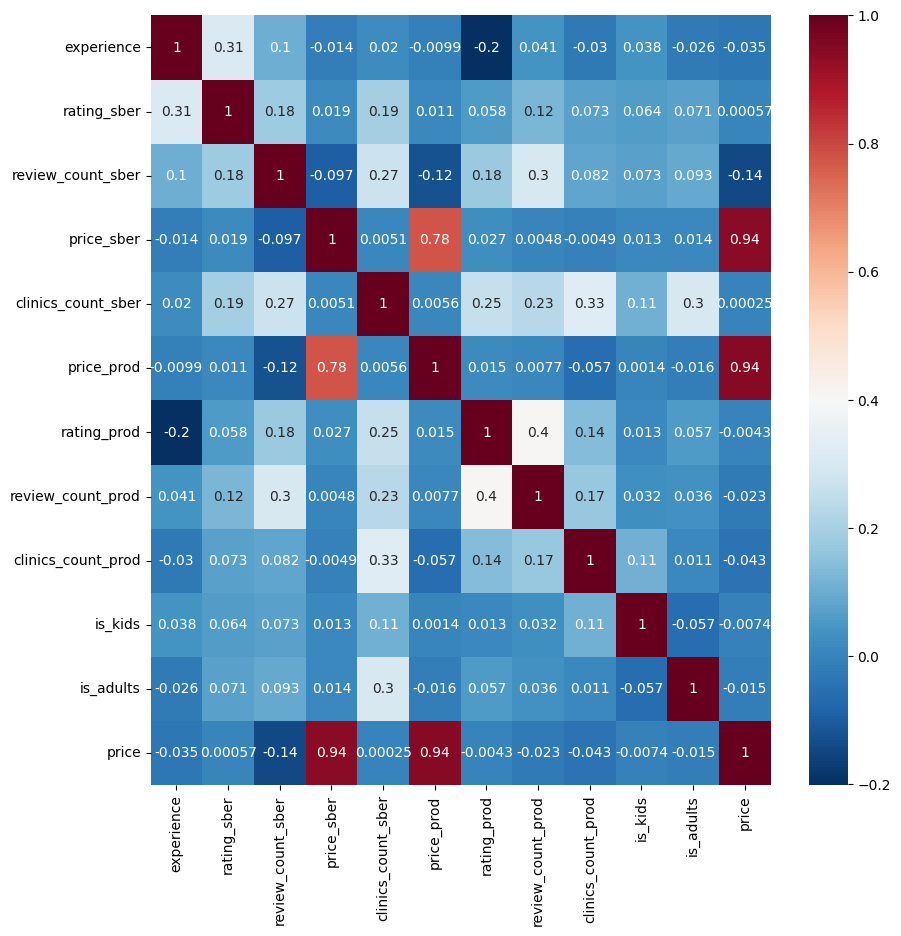

In [378]:
plt.figure(figsize=(10,10))
sns.heatmap(doctors.corr(numeric_only = True), annot=True, cmap='RdBu_r')